In [1]:
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import seaborn as sns

%matplotlib inline

plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 25,
        'axes.labelsize': 25,
        'xtick.labelsize': 22,
        'ytick.labelsize': 22,
        'font.size': 20,
        'figure.figsize': (10, 7),
        'axes.grid': True,
        'grid.linestyle': '-',
        'grid.alpha': 0.3,
        'lines.markersize': 5.0,
        'xtick.minor.visible': True,
        'xtick.direction': 'in',
        'xtick.major.size': 20.0,
        'xtick.minor.size': 10.0,
        'xtick.top': False,
        'xtick.bottom': True,
        'ytick.minor.visible': True,
        'ytick.direction': 'in',
        'ytick.major.size': 12.0,
        'ytick.minor.size': 6.0,
        'ytick.right': True,
        'errorbar.capsize': 0.0,
    })

In [ ]:
# sns.set(rc={'figure.figsize': (9, 6)})

In [2]:
events_data = pd.read_csv('event_data_train.csv')
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [61]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [62]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data['date'].dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [3]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [4]:
events_data.user_id.nunique()

19234

In [5]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [6]:
events_data.head(10)

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35
5,32811,1434340895,passed,17632,2015-06-15 04:01:35
6,32929,1434340921,discovered,17632,2015-06-15 04:02:01
7,32929,1434340921,viewed,17632,2015-06-15 04:02:01
8,32929,1434340939,started_attempt,17632,2015-06-15 04:02:19
9,32929,1434340944,passed,17632,2015-06-15 04:02:24


In [7]:
print('First timestamp')
display(events_data.date.min())
print('Last timestamp')
display(events_data.date.max())

First timestamp


Timestamp('2015-06-15 04:00:48')

Last timestamp


Timestamp('2018-05-19 23:33:31')

In [8]:
events_data['day'] = events_data['date'].dt.date

In [9]:
events_data.groupby('day').user_id.nunique().head(20)

day
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
2015-06-20    294
2015-06-21    292
2015-06-22    516
2015-06-23    520
2015-06-24    471
2015-06-25    431
2015-06-26    392
2015-06-27    334
2015-06-28    345
2015-06-29    579
2015-06-30    508
2015-07-01    476
2015-07-02    437
2015-07-03    458
2015-07-04    364
Name: user_id, dtype: int64

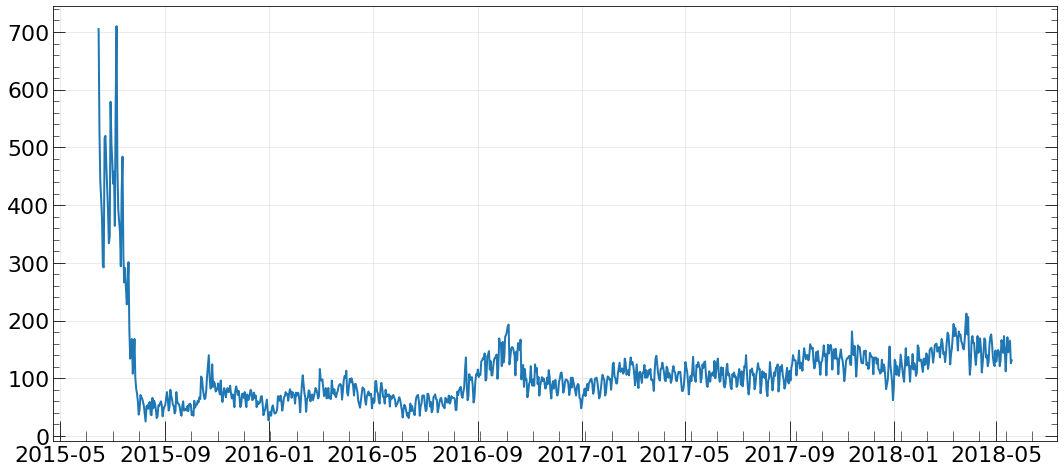

In [11]:
fig, ax = plt.subplots(1, 1, figsize=[18, 8])
plt.plot(events_data.groupby('day').user_id.nunique(), linewidth=2)

<AxesSubplot:>

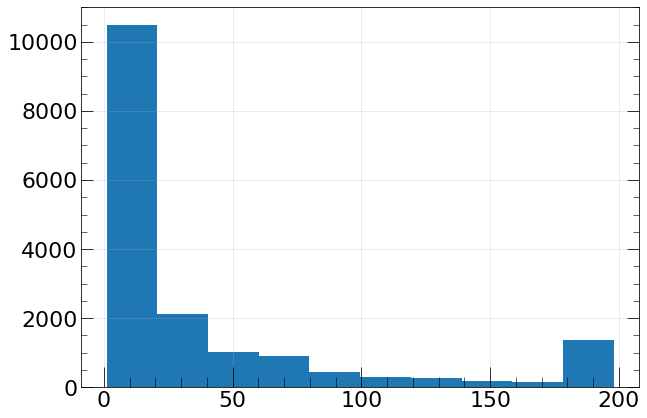

In [39]:
# Проблема тут в том, что мы выкинули юзеров, которые не прошли ни одного стэпа
events_data[events_data.action == 'passed'].groupby('user_id', as_index=False)\
    .agg({'step_id': 'count'}).rename(columns={'step_id': 'passed_steps'})\
    .passed_steps.hist()

In [46]:
events_data[events_data.action == 'passed'].groupby('user_id', as_index=False)\
    .agg({'step_id': 'count'}).step_id

0         9
1        87
2        11
3         1
4        84
         ..
17257     2
17258     8
17259    69
17260    10
17261    12
Name: step_id, Length: 17262, dtype: int64

In [49]:
print(f'N unique users before cut = {events_data.user_id.nunique()}')
print(f'N unique users after cut = {events_data[events_data.action == "passed"].user_id.nunique()}')

N unique users before cut = 19234
N unique users after cut = 17262


In [55]:
# Теперь правильное решение
events_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count',
                        fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


<AxesSubplot:>

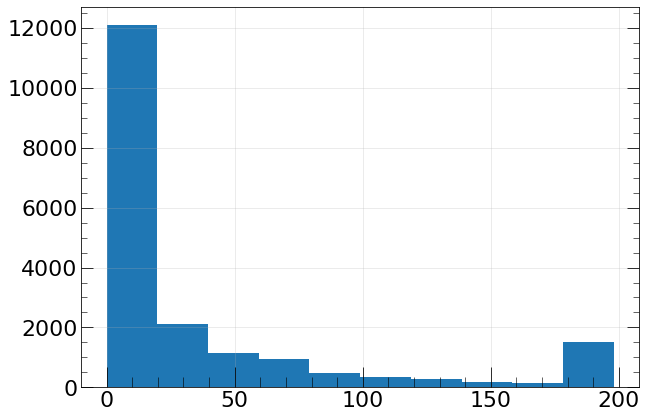

In [58]:
events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index().discovered.hist()

In [64]:
# Сколько правильных ответов у каждого юзера
users_scores = submissions_data.pivot_table(
    index='user_id',
    columns='submission_status',
    values='step_id',
    aggfunc='count',
    fill_value=0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


### Рассчитаем промежутки между заданиями (сколько юзер отсутствовал на курсе)

In [72]:
# Такая запсь оставит только одну строчку для каждого дня онлайн каждого юзера
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230
...,...,...,...
3480298,364,2018-05-19,1526762223
3480329,22851,2018-05-19,1526762629
3480333,943,2018-05-19,1526762664
3480669,26659,2018-05-19,1526770439


In [84]:
# То же самое и ещё сгруппируем пользователей по ID и сделаем список из времени решения
# np.diff() - разность между ближайшими наблюдениями (то есть получится тоже массив)

gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id')['timestamp'].apply(list)\
    .apply(np.diff).values

In [85]:
gap_data

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int64)], dtype=object)

In [86]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [87]:
# разница между двумя ближайшими заходами на курс в днях
gap_data = gap_data / (24 * 60 * 60)

<AxesSubplot:>

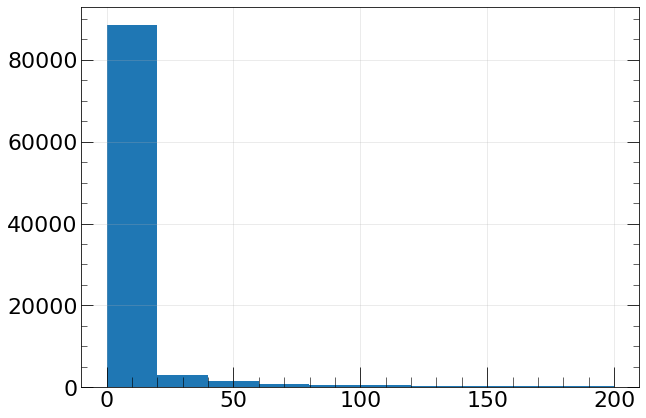

In [88]:
gap_data[gap_data < 200].hist()

In [179]:
for i in [0.80, 0.90, 0.95]:
    print(f'{i*100}% of gaps less than {round(gap_data.quantile(i), 2)}')
    
# Возьмём пороговое значение 30 дней
gap_threshold = 30.0

80.0% of gaps less than 6.0
90.0% of gaps less than 18.33
95.0% of gaps less than 59.76


In [182]:
# Вычисляем последнюю дату наблюдения 10 мая 2018
display(events_data.tail())
# last_timestamp_overall
last_timestamp_overall = events_data.loc[:, ['timestamp']].iloc[-1].values[0]
dropout_threshold = gap_threshold * 24 * 60 * 60

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [183]:
# Максимальное время (последний раз), когда пользователь появлялся на курсе
users_data = events_data.groupby('user_id', as_index=False)\
    .aggregate({'timestamp': 'max'})\
    .rename(columns={'timestamp': 'last_timestamp'})
users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [188]:
# Сколько времени прошло с момента последнего посещения до последней даты наблюдения
# и бльше ли это время, чем 30 дней
users_data['is_gone'] = (last_timestamp_overall - users_data.last_timestamp) > dropout_threshold

In [192]:
display(users_data.head())
display(users_scores.head())

,user_id,last_timestamp,is_gone
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [196]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [199]:
# eliminate NaN values
users_data = users_data.fillna(0)
users_data.head()

,user_id,last_timestamp,is_gone,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [201]:
users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

In [202]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [206]:
users_data = users_data.merge(users_events_data, on='user_id', how='outer')

In [207]:
users_data.head()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [210]:
# Число уникальных дней
users_days = events_data.groupby('user_id').day.nunique()
users_days

user_id
1        1
2        2
3        7
5        2
7        1
        ..
26790    4
26793    1
26794    9
26797    2
26798    1
Name: day, Length: 19234, dtype: int64

In [211]:
users_days = users_days.to_frame().reset_index()

In [213]:
users_days = users_days.rename(columns={'day': 'n_days'})

In [214]:
users_days

,user_id,n_days
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [216]:
users_data = users_data.merge(users_days, on='user_id', how='outer')

In [218]:
users_data.head()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,n_days
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [222]:
# Check if any data has been lost
print(f'number of users in intial data = {events_data["user_id"].nunique()}')
print(f'number of users in aggreagated data = {users_data["user_id"].nunique()}')

number of users in intial data = 19234
number of users in aggreagated data = 19234


In [223]:
# Теперь пометим юзеров, которые умпешно закончили курс
# Пусть это будут те, кто набрал более 170 баллов (шагов)
users_data['passed_course'] = users_data.passed > 170

In [224]:
users_data.head()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,n_days,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [225]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,n_days
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [227]:
users_data['passed_course'].value_counts(normalize=True)

False    0.925912
True     0.074088
Name: passed_course, dtype: float64

### Ищем Анатолия Карпова

In [109]:
# Ещё раз подгружаем датасеты, так как выше мы сбросили все заходы юзера, которые были в пределах 1 дня
submissions_data_search = pd.read_csv('submissions_data_train.csv')
events_data_search = pd.read_csv('event_data_train.csv')
#
submissions_data_search['date'] = pd.to_datetime(submissions_data_search.timestamp, unit='s')
submissions_data_search['day'] = submissions_data_search['date'].dt.date
events_data_search['date'] = pd.to_datetime(events_data_search.timestamp, unit='s')
events_data_search['day'] = events_data_search['date'].dt.date
#
events_data_search.head(10)

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
5,32811,1434340895,passed,17632,2015-06-15 04:01:35,2015-06-15
6,32929,1434340921,discovered,17632,2015-06-15 04:02:01,2015-06-15
7,32929,1434340921,viewed,17632,2015-06-15 04:02:01,2015-06-15
8,32929,1434340939,started_attempt,17632,2015-06-15 04:02:19,2015-06-15
9,32929,1434340944,passed,17632,2015-06-15 04:02:24,2015-06-15


In [148]:
# Кто решал задачки большего всего дней
events_data_search.groupby('user_id', as_index=False).agg({'day': 'nunique'})\
    .rename(columns={'day': 'n_days'}).sort_values('n_days', ascending=False).head()

,user_id,n_days
781,1046,478
9547,13268,385
3182,4374,327
7780,10794,281
2611,3572,236


In [138]:
# Топ пользователей по чсилу отправленных верных решений
submissions_data_search[submissions_data_search['submission_status'] == 'correct']\
    .groupby('user_id').aggregate({'submission_status': 'count'})\
    .sort_values('submission_status', ascending=False).head()

,submission_status
user_id,
1046,421
5552,186
17135,168
6183,142
8461,135


### Таким образом пользователь с user_id = 1046 - это Анатолий Карпов

### Preprocessed data

In [228]:
display(users_data.head())

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,n_days,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [ ]:
# Мы хотим предсказать, бросит ли пользователь курс после первых нескольких дней,
# например 5 по его активности на курсе, чтобы как-то мотивировать его остаться

In [229]:
# Медиана дней прохождения для успешно прошедших курс
users_data[users_data.passed_course == True].n_days.median()

20.0

<AxesSubplot:>

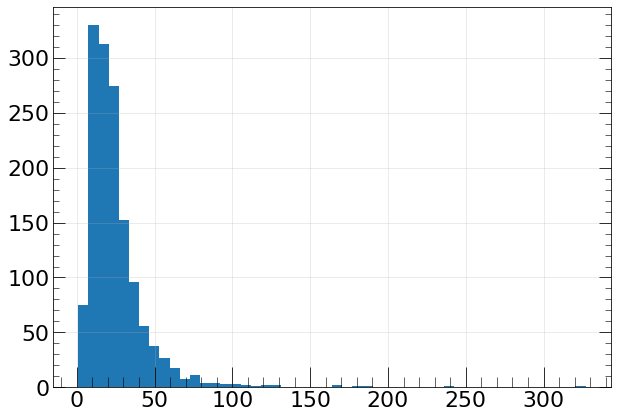

In [236]:
# Сколько дней потратили на курс те, кто его прошёл
users_data[users_data.passed_course == True].n_days.hist(bins=50)

### Отбираем для каждого юзера события только за первые 3 дня на курсе

In [243]:
user_min_time = events_data.groupby('user_id', as_index=False).agg({'timestamp': 'min'})\
    .rename({'timestamp': 'min_timestamp'}, axis=1)

# Добавляем в датафрейм по юзерам
users_data = users_data.merge(user_min_time, on='user_id', how='outer')

In [267]:
# Отфильтруем события только за первые 3 дня на курсе
time_to_study = 3 * 24 * 60 * 60
events_data

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


### Фильтрация с применением merge

In [289]:
# Присоедениям к датафрейму с событиями колонку min_timestamp (так можно, хоть они и разной длины)
event_data_train = events_data.merge(users_data[['user_id', 'min_timestamp']], on='user_id', how='left')
event_data_train['time_delta'] = event_data_train['timestamp'] - event_data_train['min_timestamp']

In [291]:
# И теперь просто отрезаем по параметру time_to_study
event_data_train = event_data_train.loc[event_data_train['time_delta'] < time_to_study]
event_data_train

,step_id,timestamp,action,user_id,date,day,min_timestamp,time_delta
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,0
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,0
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,0
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,47
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,47
...,...,...,...,...,...,...,...,...
3480530,32953,1526766998,viewed,24555,2018-05-19 21:56:38,2018-05-19,1526729867,37131
3480531,32953,1526766998,discovered,24555,2018-05-19 21:56:38,2018-05-19,1526729867,37131
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750,0
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750,0


### Как это предлагается делать на курсе

In [295]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [298]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [300]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + time_to_study).map(str)

In [302]:
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [303]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [308]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [309]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [311]:
event_data_train2 = events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [314]:
event_data_train2.shape

(1014985, 8)

### Поиск стэпа, на котором застряло нибольшее количество пользователей

In [362]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [363]:
submissions_data_wrong = submissions_data.loc[submissions_data.submission_status == 'wrong']
submissions_data_wrong_max_time = submissions_data_wrong\
    .groupby(['user_id'], as_index=False).agg({'timestamp': 'max'})\
    .rename({'timestamp': 'max_timestamp'}, axis=1)

In [364]:
submissions_data_wrong_max_time.head()

,user_id,max_timestamp
0,3,1444568755
1,5,1499859715
2,8,1480604128
3,14,1436368601
4,16,1513104380


In [365]:
submissions_data_wrong = submissions_data_wrong.merge(submissions_data_wrong_max_time, on='user_id', how='left')

In [366]:
submissions_data_wrong.head()

,step_id,timestamp,submission_status,user_id,max_timestamp
0,31972,1478852149,wrong,15853,1479734102
1,31976,1434348123,wrong,15853,1479734102
2,32031,1434363465,wrong,15853,1479734102
3,32795,1434520465,wrong,15853,1479734102
4,32812,1434346160,wrong,15853,1479734102


In [367]:
submissions_data_wrong_drop_step = submissions_data_wrong[submissions_data_wrong['timestamp'] == submissions_data_wrong['max_timestamp']]

In [390]:
submissions_data_wrong_drop_step.groupby('step_id').agg({'step_id': 'count'})\
    .rename({'step_id': 'step_id_counts'}, axis=1)\
    .sort_values('step_id_counts', ascending=False)

,step_id_counts
step_id,
32812,867
31978,697
33669,402
31971,305
31972,294
...,...
31988,10
33674,9
33413,9


### Фигня какая-то, попробую по-другому
Кажется, я просто не правильно понял задачу. Там нужен был стэп с наибольшим числом неверных сабмитов,
а не тот, после которого люди отваливались с курса

In [391]:
submissions_data.loc[submissions_data['submission_status'] == 'wrong']\
    .groupby('step_id', as_index=False).aggregate({'submission_status': 'count'})\
    .rename({'submission_status': 'submission_status_counts'}, axis=1)\
    .sort_values('submission_status_counts', ascending=False).head()

,step_id,submission_status_counts
4,31978,16084
11,32031,13373
19,32202,13002
44,33481,10300
12,32075,10003


In [393]:
# Вот ещё прикол
submissions_data.loc[submissions_data['submission_status'] == 'wrong'].step_id.mode()

0    31978
dtype: int64

### Возвращаемся к задаче

In [400]:
event_data_train.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp,time_delta
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,0
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,0
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,0
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,47
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,47


In [401]:
event_data_train.groupby('user_id').day.nunique().max()

4

In [426]:
# Снова загружаем данные о задачках
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data['date'] = pd.to_datetime(submissions_data_search.timestamp, unit='s')
submissions_data['day'] = submissions_data_search['date'].dt.date

In [422]:
# Добавляем в submissions_data время первого степа
submissions_data = submissions_data.merge(user_min_time, on='user_id', how='left')
# Время от первого степа до последнего
submissions_data['users_time'] = submissions_data['timestamp'] - submissions_data['min_timestamp']
# Выбираем степы первых трёх дней
submissions_data_train = submissions_data[submissions_data.users_time <= time_to_study]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [429]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp,user_learning_time_threshold,users_time
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1434345977,15853_1434605177,3298
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1434345977,15853_1434605177,2323
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,1434345977,15853_1434605177,44506172
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,1434345977,15853_1434605177,44506187
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434345977,15853_1434605177,2146


In [430]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index()

In [432]:
X.head()

,user_id,day
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [444]:
# Сколько степов человек пытался решить за первые 3 дня
steps_tried = submissions_data_train.groupby(['user_id'], as_index=False)\
    .agg({'step_id': 'nunique'}).rename({'step_id': 'steps_tried'}, axis=1)

In [446]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [449]:
X.rename(columns={'day': 'days'}, inplace=True)

In [450]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [463]:
# Добавим колонки с чсилом правильных и неправльных попыток решения у каждого юзера
attempsts_data = submissions_data_train.pivot_table(index='user_id',
                                  columns='submission_status',
                                  values='step_id',
                                  aggfunc='count',
                                  fill_value=0).reset_index()
attempsts_data.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,23,27


In [456]:
X = X.merge(attempsts_data, on='user_id', how='outer')
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


In [457]:
# Добавим фичу
X['correct ratio'] = X.correct / (X.correct + X.wrong)
X.head()

,user_id,days,steps_tried,correct,wrong,correct ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [468]:
# Сколько степов было просмотрено у каждого пользователя
# Это из датасета с событиями event_data_train
actions_data = event_data_train.pivot_table(index='user_id',
                                  columns='action',
                                  values='step_id',
                                  aggfunc='count',
                                  fill_value=0).reset_index()
actions_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,9
2,3,15,15,4,20
3,5,1,1,0,1
4,7,1,1,0,1


In [469]:
X = X.merge(actions_data[['user_id', 'viewed']], on='user_id', how='outer')

In [472]:
# Заполним пропуски нулями
X = X.fillna(0)

In [476]:
# Добаляем информацию про каждого юзера: прошёл ли он курс и дропнулся ли он
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone']], on='user_id', how='outer')

In [481]:
# Отбросим пользователей, которые ещё проходят курс, то есть начали, но
# не бросили и ещё не закончили
X = X.loc[~((X['passed_course'] == False) & (X['is_gone'] == False))]

In [483]:
# Проверим, всё ли сработало как надо
X.groupby(['passed_course', 'is_gone']).user_id.count()

passed_course  is_gone
False          True       16560
True           False        141
               True        1284
Name: user_id, dtype: int64

In [490]:
# Целевая переменная
y = X.passed_course.map(int)
X = X.drop(columns=['passed_course', 'is_gone'])

In [492]:
# Перенесём user_id в индекс, чтобыон не мешался нам в данных
X = X.set_index(X.user_id)
X = X.drop(columns=['user_id'])
X.head()

,days,steps_tried,correct,wrong,correct ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
